In [2]:
# Basic packages.
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
tf.config.run_functions_eagerly(True)

# Visualization packages.
import seaborn as sns
import matplotlib.pyplot as plt

# Necessary variables for file exploration.
DATA_DIR = 'data'
TRANSFORMED_DIR = 'transformed'
feature_file = 'transformed_features.csv'
response_file = 'transformed_responses.csv'

# Read in the data.
feature_df = pd.read_csv('../{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, feature_file))
response_df = pd.read_csv('../{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, response_file))
feature_df.shape, response_df.shape

# Convert date to str & set as index.
feature_df['DATE'] = pd.to_datetime(feature_df['DATE'])
feature_df.set_index('DATE', drop=True, inplace=True)
response_df['Date'] = pd.to_datetime(response_df['Date'])
response_df.set_index('Date', drop=True, inplace=True)

# Normalize data frame.
normalized_df = (feature_df - feature_df.mean()) / feature_df.std()

dates = np.array(feature_df.index)
# Add 1 to include December as a part of the train.
training_ends = np.where(dates == pd.to_datetime("2009-12-01"))[0][0] + 1
test_ends = np.where(dates == pd.to_datetime("2019-12-01"))[0][0] + 1
X_train, X_test, X_analysis = normalized_df.iloc[:training_ends, :], normalized_df.iloc[training_ends:test_ends, :], normalized_df.iloc[test_ends:, :]
y_train, y_test, y_analysis = response_df['Equity Indices Market'].iloc[:training_ends], response_df['Equity Indices Market'].iloc[training_ends:test_ends], response_df['Equity Indices Market'].iloc[test_ends:]
X_train.shape, X_test.shape, X_analysis.shape

((216, 58), (120, 58), (19, 58))

In [3]:
def graphHistory(history, title):
    """
    Function for graphing the training and valiedation accuracy and loss
    ...
    :param history - history object from keras desired to plot.
    :param title - str that will be the title of the resulting plot.
    """
    # summarize history for accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    #axes[0].title('Model Accuracy ' + title)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Tr. Acc', 'Val. Acc'])

    # summarize history for loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    #axes[1].title('Model Loss ' + title)
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Tr. Loss', 'Val. Loss'])
    plt.tight_layout()
    plt.title(title)
    plt.show()

    # define a fx. to split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [4]:
# Still predicting equities --> col_num 0 in our y data
n_steps = 12
train_dataset = np.hstack((X_train.values, y_train.values.reshape(y_train.shape[0], 1)))
X_train, y_train = split_sequences(train_dataset, n_steps)
test_dataset = np.hstack((X_test.values, y_test.values.reshape(y_test.shape[0], 1)))
X_test, y_test = split_sequences(test_dataset, n_steps)
analysis_dataset = np.hstack((X_analysis.values, y_analysis.values.reshape(y_analysis.shape[0], 1)))
X_analysis, y_analysis = split_sequences(analysis_dataset, n_steps)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((205, 12, 58), (205,), (109, 12, 58), (109,))

In [5]:
# Define the model.
n_features = X_train.shape[2]
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features), kernel_initializer='he_normal', use_bias=True))
cnn.add(tf.keras.layers.Dropout(0.3))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal', use_bias=True))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.Dense(1))
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.MeanAbsoluteError(), metrics='accuracy')
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 11, 64)            7488      
_________________________________________________________________
dropout (Dropout)            (None, 11, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                16050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

2021-09-06 17:28:55.258539: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2021-09-06 17:28:56.508946: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
7/7 [==============================] - 0s 20ms/step - loss: 4.2343 - accuracy: 0.0000e+00 - val_loss: 8.2777 - val_accuracy: 0.0000e+00
Epoch 2/200
7/7 [==============================] - 0s 16ms/step - loss: 9.0442 - accuracy: 0.0000e+00 - val_loss: 15.9145 - val_accuracy: 0.0000e+00
Epoch 3/200
7/7 [==============================] - 0s 16ms/step - loss: 4.0826 - accuracy: 0.0000e+00 - val_loss: 2.4138 - val_accuracy: 0.0000e+00
Epoch 4/200
7/7 [==============================] - 0s 16ms/step - loss: 3.5225 - accuracy: 0.0000e+00 - val_loss: 2.4070 - val_accuracy: 0.0000e+00
Epoch 5/200
7/7 [==============================] - 0s 16ms/step - loss: 3.4787 - accuracy: 0.0000e+00 - val_loss: 2.4172 - val_accuracy: 0.0000e+00
Epoch 6/200
7/7 [==============================] - 0s 16ms/step - loss: 3.4569 - accuracy: 0.0000e+00 - val_loss: 2.4689 - val_accuracy: 0.0000e+00
Epoch 7/200
7/7 [==============================] - 0s 19ms/step - loss: 3.3802 - accuracy: 0.0000e+00 - val_los

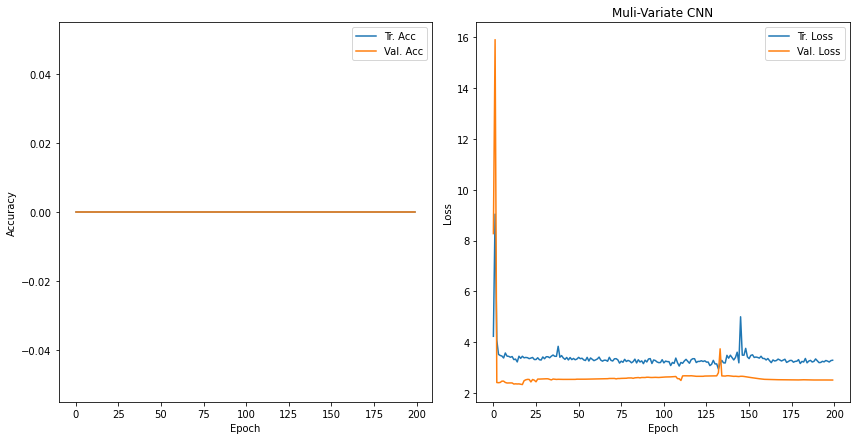

In [6]:
history = cnn.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), shuffle=False)
graphHistory(history, "Muli-Variate CNN")

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


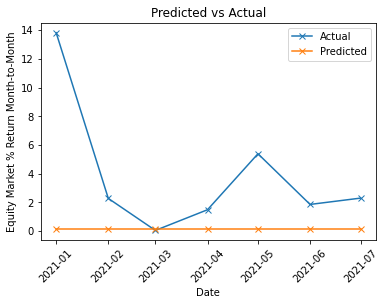

In [10]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# Plot all test data and then validation data and prediction data...
dates_test, dates_y_test = split_sequence(dates[training_ends: test_ends], 12)
dates_val, dates_y_val = split_sequence(dates[test_ends:], 12)
dates_test.shape, dates_val.shape, dates_y_test.shape, dates_y_val.shape
actual_dates = np.hstack((dates_y_test, dates_y_val))
preds = cnn.predict(X_analysis)
pred_vals = preds.reshape(preds.shape[0], )
pred_dates = dates_y_val
plt.plot(pred_dates, y_analysis[:-1], label='Actual', marker='x')
plt.plot(pred_dates, pred_vals[:-1], label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('Equity Market % Return Month-to-Month')
plt.title('Predicted vs Actual')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


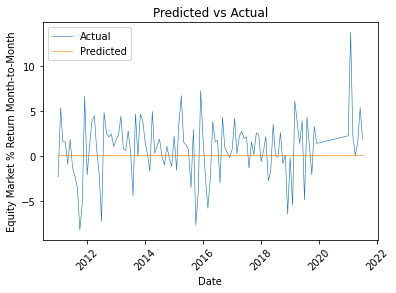

In [14]:
# Plot all test data and then validation data and prediction data...
dates_test, dates_y_test = split_sequence(dates[training_ends: test_ends], 12)
dates_val, dates_y_val = split_sequence(dates[test_ends:], 12)
dates_test.shape, dates_val.shape, dates_y_test.shape, dates_y_val.shape
actual_dates = np.hstack((dates_y_test, dates_y_val))
actual_vals = np.hstack((y_test, y_analysis.reshape(y_analysis.shape[0], )))
test_preds = cnn.predict(X_test)
pred_vals = np.hstack((preds.reshape(preds.shape[0], ), test_preds.reshape(test_preds.shape[0], )))
pred_dates = dates_y_val 
plt.plot(actual_dates, actual_vals[:-2], label='Actual', linewidth=0.6)
plt.plot(actual_dates, pred_vals[:-2], label='Predicted', linewidth=0.6)
plt.xlabel('Date')
plt.ylabel('Equity Market % Return Month-to-Month')
plt.title('Predicted vs Actual')
plt.xticks(rotation = 45)
plt.legend()
plt.show()